<a href="https://colab.research.google.com/github/CMallart/ateliers-NN/blob/main/Creation_de_paysages_par_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative adversarial networks : motivation

Les réseaux de neurones peu profonds sont somme toute des versions un peu compliquées de classifieurs statistiques, utilisés le plus souvent pour classifier des objets (phrases, images, audio, videos...) en plusieurs catégories.Il faut leur créer des variables(features) à la main et espérer que cela leur parle.

Mais les réseaux de neurones profonds, eux, permettent de faire quelque chose de beaucoup plus puissante : ils apprennent des représentations. Ils peuvent apprendre directement, sans création de features à la main, des représentations par matrices d'objets complexes, comme des images. Vous avez vu comment les CNN passent d'une image en deux dimensions, trois couleurs, à parfois un seul petit vecteur qui vous dit "chat ou chien". Ou comment un LSTM peut résumer en un vecteur toute l'information d'une phrase. C'est sur ce "résumé" de l'information en quelques vecteurs que se trouve la vraie nouveauté des réseaux de neurones profonds. Cela serait dommage de ne pas exploiter cela pour quelque chose de plus puissant, ou au moins de différent. 

Entrent en jeu les réseaux génératifs. Ces réseaux profitent du fait qu'on peut apprendre à un réseau à créer une représentation abstraite, vectorielle, d'un objet. Et si l'on peut partir d'un objet (disons image dans notre cas ici), et avoir un vecteur représentatif, pourquoi pas partir d'un vecteur représentatif et reconstruire toute une image ? Si ce vecteur est nouveau, l'image de fin sera nouvelle aussi, on aura généré des images qui n'existaient pas auparavant.

https://thispersondoesnotexist.com/ est un exemple de ce qu'on peut faire avec des GAN (très) avancés et entrainés (trèèèès) longtemps sur suffisamment de données (comprendre : beaucoup et de très bonne qualité)

#Révision : architecture d'un GAN

Un GAN est un réseau génératif adversarial (ou Generative Adversarial Network). Toute l'idée se trouve dans le nom : on génère des choses, avec un adversaire qui essaye de contrecarer nos plans.

Il y a deux morceaux, le faussaire (le générateur) et l'expert (le discriminateur). Le role du faussaire est de créer des images qui ressemblent tellement à des vraies que l'expert se trompe. L'expert, lui, doit s'entrainer à reconnaitre les contrefacons pour être toujours capable de dénoncer le faussaire.

L'expert est un réseau de classification supervisé comme vous en avez déjà vu : il a des images, classifiées vraies ou fausses, et apprend ce que doit être une "vraie" image. Il donne donc des scores aux images, la probabilité que l'image soit véritable.

Le faussaire, lui, part d'une représentation initiale simple, juste pour lui donner un point de départ : un vecteur de dimension 100, fait de bruit. De cela, il convolutionne, upsample et possède tout un tas de couches pour en faire une image de dimension donnée. Au début, c'est moche : ce n'est que des convolutions sur du bruit. Mais au fur et à mesure de l'entrainement, l'expert lui dit qu'une image a été vue comme contrefacon ou non. Et le générateur modifie donc ses poids au fur et à mesure pour que l'image ressemble de plus en plus à ce que le discriminateur considère comme "véritable".

C'est donc un entrainement avec deux temps pour chaque époque : d'abord le discriminateur seul, puis on "gèle" l'état du discriminateur, et on entraine le générateur. Et on recommence sur le prochain batch : on entraine le discriminateur, puis le generateur. On espere qu'a la fin, en les ayant entraines conjointement, ils auront appris l'un de l'autre.

#Mots de precaution

Cela a l'air simple dit comme ca, mais les entrainements de GAN sont tout sauf stables. Il n'existe pas de résulat mathématique qui permette de trouver des configurations stables aux GAN. Cela se trouve grâce à la pratique, à l'experience, et avec un nombre non-négligeable d'essais d'hyperparamètres.

Un autre problème est de reconnaitre la qualité des images générées pour savoir quand stopper l'entrainement. D'habitude, on a des précisions, des loss, des scores qui permettent de savoir quand on commence à sur-entrainer. Mais quand il n'y a pas de "gold truth", de "vérité" car on ne fait que juger de la qualité visuelle d'une image, comment faire ?
Plusieurs métriques assez compliquées existent. Une autre méthode, que nous allons appliquer ici, est de sauvegarder le modèle régulièrement, de regarder quelques générations d'images, et de choisir le modèle qui rend les images les plus visuellement satisfaisantes.




# Imports / setup

<font color = "red"> Vérifiez bien que vous êtes dans un type d'execution "GPU" ! Sinon vous entrainerez vos modeles pendant trois jours. </font>

Barre d'outils > Execution > Modifier le type d'éxécution > Accélérateur matériel > GPU

A faire depuis le début, on ne peut pas changer en cours de route.

Data from :
https://www.kaggle.com/arnaud58/landscape-pictures


In [1]:
! git clone https://github.com/CMallart/ateliers-NN.git

Cloning into 'ateliers-NN'...
remote: Enumerating objects: 2922, done.
remote: Counting objects: 100% (2922/2922), done.
remote: Compressing objects: 100% (2895/2895), done.
remote: Total 7092 (delta 47), reused 2876 (delta 26), pack-reused 4170
Receiving objects: 100% (7092/7092), 631.26 MiB | 42.46 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Checking out files: 100% (7162/7162), done.


In [2]:
! ls

ateliers-NN  sample_data


In [3]:
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy.random import choice
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot
from google.colab import files
import os

#Data

In [4]:
train_generator = ImageDataGenerator(rescale=1/255,fill_mode="reflect")
train_flow = train_generator.flow_from_directory("/content/ateliers-NN/data/landscapes", class_mode=None, target_size=(128,128), batch_size=4319)

Found 4319 images belonging to 1 classes.


In [5]:
#Notre dataset n'est pas immense : il est possible de le mettre en mémoire pour que l'entrainement ne soit pas trop long.
#Sinon, la majorité de l'entrainement consiste à attendre le retour du nouveau batch de flow_from_directory

dataset_train = []
print("Starting")
temp_data = train_flow.next()
for i in range(temp_data.shape[0]):
  dataset_train.append(temp_data[i])
dataset = np.array(dataset_train)
print("Done")

Starting
Done


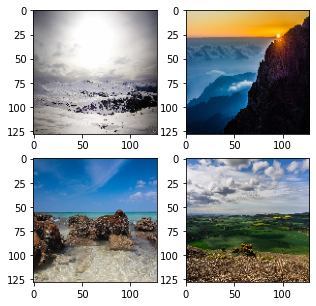

In [6]:
# visualisation de quelques images

plt.figure(figsize=(5, 5))
plt.subplot(221)
plt.imshow((dataset[0]))

plt.subplot(222)
plt.imshow((dataset[1]))

plt.subplot(223)
plt.imshow((dataset[2]))

plt.subplot(224)
plt.imshow((dataset[3]))

plt.show()

Question : Une discussion importante à avoir ici est celle de la qualité des données. Qu'en pensez-vous de premier abord ?
Vous pouvez vous concentrer sur :
- l'uniformité
- la variété
- le détail
- les couleurs
- la taille
- et tout ce qui vous semble pertinent 

Quel serait l'impact de tout cela dans l'entrainement ?

In [7]:
# pour entrainer le discriminateur, on a besoin de deux types d'images : des vraies et des fausses.

# les vraies viennent de notre dataset
def generate_real_samples(dataset, n_samples):
	#selectionner n_samples images au hasard
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	# créer les labels "vrai" (1)
	y = ones((n_samples, 1))
	#inverser 5% des labels
	y = noisy_labels(y, 0.05)
	return X, y

# les fausses sont celles crées par le générateur
def generate_fake_samples(g_model, latent_dim, n_samples):
	# générer un bruit de taille 100, que l'on appelle l'espace latent
	x_input = generate_latent_points(latent_dim, n_samples)
	# generer une image a partir de ce bruit
	X = g_model.predict(x_input)
	# créer les labels "faux" (0)
	y = zeros((n_samples, 1))
	#y = y+0.1
	#inverser 5% des labels
	y = noisy_labels(y, 0.05)
	return X, y


# générateur de bruit aléatoire, de taille celle de l'espace latent
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


# hack number 1 : inversion des labels
# parfois, pour éviter la non-convergence, on "trompe" le discriminateur en inversant quelques images vraies/fausses
# voir la présentation NIPS de Soumith Chintala (un des inventeurs du DCGAN).
def noisy_labels(y, p_flip):
	# quantité de labels à inverser
	n_select = int(p_flip * y.shape[0])
	# lequels on inverse
	flip_ix = choice([i for i in range(y.shape[0])], size=n_select)
	# inverser en place
	y[flip_ix] = 1 - y[flip_ix]
	return y

#Model

In [8]:
#Définir le discriminateur (l'expert)

def define_discriminator(in_shape=(128,128,3), lr = 0.0004): #/!\ la taille ici est calibrée sur la taille des images d'entrainement
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifieur
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compiler le model
	opt = Adam(lr=lr, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [9]:
#Définir le générateur (le faussaire)

def define_generator(latent_dim):
	model = Sequential()
	# avoir assez de channels pour une image 8x8
	n_nodes = 256 * 8 * 8
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 256)))
	# upsample 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample 64x64
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
 	# upsample 128x128
	model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same'))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))

	# derniere convolution
	model.add(Conv2DTranspose(16, (5,5), padding='same'))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))

	# output layer
	model.add(Conv2D(1, (3,3), activation='tanh', padding='same'))
	return model

Question : pourquoi tous ces nodes au début ? Qu'est-ce que cela pourrait bien faire dans ce réseau, et pourquoi autant ?

Note : vous voyez que l'on a pas encore compilé le générateur, contrairement au discriminateur. C'est parce que le discriminateur vit sa vie tout seul, il n'a besoin que d'images annotées vraies/fausses, alors que le générateur a besoin d'être mis dans le GAN en entier pour pouvoir être entrainé. On attend donc le modèle GAN général pour compiler de générateur.

In [10]:
# définir le modèle GAN en entier, pour compiler le générateur 

def define_gan(g_model, d_model, lr = 0.0001):
	# empêcher l'entrainement du discriminateur à cette étape
	d_model.trainable = False
	# connecter discri/géné
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	# compile model
	#hack number 2 : learning rate différent
	opt = Adam(lr=lr, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Note : remarquez que les learning rates ne sont pas les mêmes pour le générateur et le discriminateur. C'est un trick souvent utilisé pour éviter le problème de la non-convergence : quand soit le discriminateur soit le générateur devient tellement bon, qu'il marche à tous les coups, et empêche l'entrainement de l'autre. Puisque souvent, c'est le générateur qui comprend vite comment tromper le discriminateur, on lui donne ici un plus petit learning rate, pour donner une chance au discriminateur d'apprendre plus vite comment repérer les fausses images.

D'autres "hacks" comme ceux-là sont présents dans ce TP. Car on le répère, faire converger un GAN, c'est dur.

# Fonctions utiles pour visualiser/sauver les modèles

In [11]:
# Pour sauver les plots et les modèles.
# Il y a possibilité soit 
	# de sauver les figures et les modèles dans votre drive avec plt.savefig : il faut mettre le bon chemin dans folder_saves et commenter la ligne files.download dans les fonctions suivantes
	# de télécharger les plots et les modèles : files.download et commenter plt.savefig
	# soit faire les deux, et ne rien commenter

#Attention, files.download est long, surtout avec les modèles.

folder_saves = "/content/drive/My Drive/Colab_Notebooks/plots_gan/"
if not os.path.exists(folder_saves):
    os.makedirs(folder_saves)

In [12]:
def save_plot(examples, epoch, n=7):
	# remettre l'output qui est dans l'espace [-1,1] dans l'espace [0,1]
	examples = (examples + 1) / 2.0

  #créer le plot de tous les exemples donnés
	plt.figure(figsize=(40, 40))
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i])
  
	# sauvegarder le plot
	filename = folder_saves+'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.plot()
	#files.download(filename) 


# évaluer le discriminateur, plot les images, sauver le modèle générateur
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# évaluer sur exemples vrais
	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
 
	# évaluer sur exemples faux
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
 
	# print les performances
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
 
	# sauvegarder les choses
	save_plot(x_fake, epoch)
	filename = folder_saves+'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)
	#files.download(filename)

# Entrainement !

In [13]:
# parametres
latent_dim = 100
epochs =400
batchsize = 64
lr_discri = 0.0004
lr_gan = 0.0001

Question : sur quelques époches (30 max), faites varier les paramètres et observez ce qui se passe. 

In [14]:
# entrainement conjoint
# on fait à la main chaque époque et chaque batch, pour voir la mécanique sous-jacente.

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30, n_batch=128):
	bat_per_epo = int(4335 / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			# entrainer le discinimateur sur les exemples "vrais"
			X_real, y_real = generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
	 
			# entrainer le discinimateur sur les exemples "faux"
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
	 
			# générer du bruit comme input pour le générateur, avec comme label "vrai"
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))

			# entrainer le générateur grace à l'erreur du disciminateur
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
	 
	 		#prints pour évaluer le modèle, chaque dixieme batch
			if (j+1)%10 == 0 :
				print('>Epoch :%d, Batch : %d/%d, discrim_real_loss=%.3f, discrim_fake_loss=%.3f gan_loss=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		#chaque dixieme epoque, on sauve le modele, les plots et tout le reste
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim, n_samples=256)

Question : avez-vous compris pourquoi on met le label "vrai" aux images générées pour entrainer le GAN ?

In [15]:
# create the discriminator
d_model = define_discriminator(lr_discri)
# create the generator
g_model = define_generator_mnist(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model, lr_gan)
# train model
train(g_model, d_model, gan_model, x, latent_dim, n_epochs=epochs, n_batch = batchsize)

TypeError: ignored